In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# unzip file
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset2C-20240422T052137Z-001.zip', 'r') # 'r' for read
zip_ref.extractall('/content') # extract to content file
zip_ref.close()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import cv2
import PIL

In [4]:
data = '/content/Dataset2C'

In [5]:
# def color_histogram(nameOfFruits, dataPath):
#     fig, axs = plt.subplots(len(nameOfFruits), 1, figsize=(10, 5 * len(nameOfFruits)))

#     for i, fruitName in enumerate(nameOfFruits):
#         fruit_folder = os.path.join(dataPath, fruitName)
#         image_files = os.listdir(fruit_folder)
#         image_path = os.path.join(fruit_folder, image_files[0])
#         image = PIL.Image.open(image_path)
#         image_array = np.array(image)

#         color_labels = ['Red', 'Green', 'Blue']
#         colors = ['r', 'g', 'b']

#         for j, (color, label) in enumerate(zip(colors, color_labels)):
#             color_values = image_array[:,:,j].flatten()
#             axs[i].hist(color_values, bins=256, color=color, alpha=0.5, label=label)

#         axs[i].set_xlabel('intensity')
#         axs[i].set_ylabel('frequency')
#         axs[i].set_title(f'{fruitName} color histogram')

#     plt.tight_layout()
#     plt.show()

In [6]:
# fruits = ['cashew', 'cempedak', 'coconut', 'cranberry']
# color_histogram(fruits, data)

Color Histogram:


1.   Cashew: distribusi intensity dari Cashew tidak begitu baik dimana ada 1 peak yang tinggi di warna blue dan selanjutnya datar dan rendah, ini menandakan warna yang tidak seimbang dikarenakan adanya peak tersebut (blue lebih dominan). Persebaran intensity juga tidak begitu lebar dan lebih cenderung ke kiri sehingga bisa disimpulkan adanya contrast yang rendah dan juga brightness yang kurang.
2.   Cempedak: distribusi intensity dari Cempedak juga memiliki peak yang tinggi di warna blue dan juga peak yang lebih tinggi di warna red dan warna green yang kurang terlihat ada peak, tinggi dari frequency intensity juga tidak seimbang di kiri dan kanan sehingga warna tidak seimbang. Persebaran intensity lebar tetapi lebih cenderung ke kiri sehingga bisa disimpulkan contrast tinggi tapi brightness yang kurang.
3.   Coconut: distribusi intensity dari Coconut juga memiliki peak yang sangat tinggi untuk warna blue sehingga warna blue lebih dominan. Persebaran intensity sangat lebar dan lebih cenderung ke kanan sedikit. Bisa disimpulkan contrast tinggi dan brightness yang cukup baik.
4.   Cranberry: distribusi intensity tidak baik, ada peak yang tinggi untuk warna blue. Persebaran tidak begitu lebar dan cenderung ke kiri. Bisa disimpulkan warna tidak seimbang, contrast rendah dan brightness yang kurang baik.



In [5]:
data = pathlib.Path(data)
data

PosixPath('/content/Dataset2C')

In [6]:
image_length = len(list(data.glob('*/*.jpg')))
image_length

1610

In [7]:
fruit_image = {
    'cashew': list(data.glob('cashew/*')),
    'cempedak': list(data.glob('cempedak/*')),
    'coconut': list(data.glob('coconut/*')),
    'cranberry': list(data.glob('cranberry/*'))
}

In [8]:
fruit_image_index = {
    'cashew': 0,
    'cempedak': 1,
    'coconut': 2,
    'cranberry': 3
}

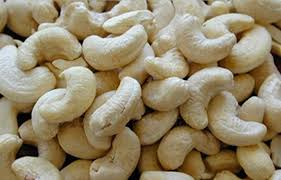

In [11]:
PIL.Image.open(str(list(data.glob('cashew/*'))[14]))

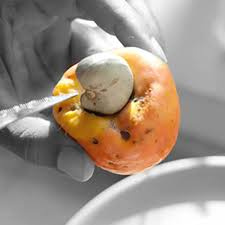

In [12]:
PIL.Image.open(str(list(data.glob('cashew/*'))[3]))

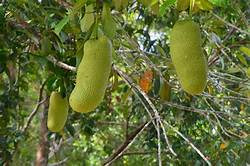

In [13]:
PIL.Image.open(str(list(data.glob('cempedak/*'))[0]))

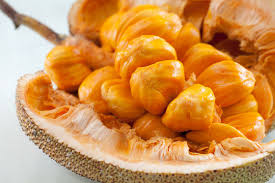

In [14]:
PIL.Image.open(str(list(data.glob('cempedak/*'))[60]))

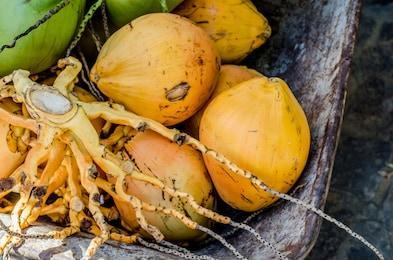

In [15]:
PIL.Image.open(str(list(data.glob('coconut/*'))[0]))

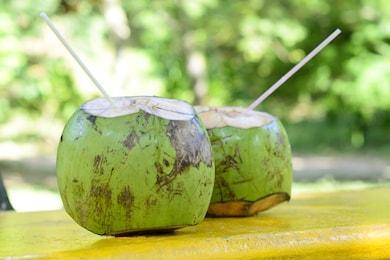

In [16]:
PIL.Image.open(str(list(data.glob('coconut/*'))[142]))

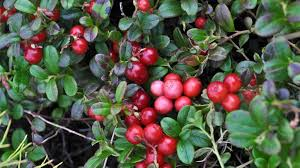

In [17]:
PIL.Image.open(str(list(data.glob('cranberry/*'))[0]))

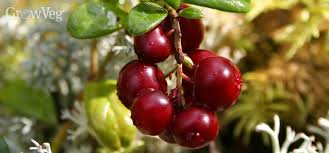

In [18]:
PIL.Image.open(str(list(data.glob('cranberry/*'))[130]))

In [9]:
X, y = [], []

for fruit_name, images in fruit_image.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (224, 224))
    X.append(resized_img)
    y.append(fruit_image_index[fruit_name])

In [10]:
X[0].shape

(224, 224, 3)

In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Testing set size:", len(x_test))

Training set size: 1288
Validation set size: 161
Testing set size: 161


In [13]:
data_aug = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (224, 224, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

Data Augmentation diimplementasikan dengan adanya Random Flip secara horizontal untuk melihat dari perspective yang berbeda, ada juga input shape yang akan digunakan nanti di dalam model. Berikutnya ada Random Zoom dimana image akan di zoom in atau zoom out agar bisa dilihat lebih dekat atau jauh, karena ada image yang zoom ke buahnya. Selanjutnya ada Random Rotation dimana image akan di rotasikan untuk melihat dari arah yang berbeda. Terakhir ada Random Contrast untuk meningkatkan atau menurunkan contrast dari image karena dari histogram di atas dapat diketahui banyak yang tingkat contrastnya kurang baik.

In [14]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False

model = Sequential([
    data_aug,
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 

In [15]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/20
41/41 [==============================] - 23s 283ms/step - loss: 42.9246 - accuracy: 0.7337 - val_loss: 1.2506 - val_accuracy: 0.8571
Epoch 2/20
41/41 [==============================] - 7s 169ms/step - loss: 0.5120 - accuracy: 0.9325 - val_loss: 0.7731 - val_accuracy: 0.9193
Epoch 3/20
41/41 [==============================] - 8s 187ms/step - loss: 0.2876 - accuracy: 0.9573 - val_loss: 0.4112 - val_accuracy: 0.9130
Epoch 4/20
41/41 [==============================] - 7s 167ms/step - loss: 0.3609 - accuracy: 0.9542 - val_loss: 1.9771 - val_accuracy: 0.8634
Epoch 5/20
41/41 [==============================] - 7s 167ms/step - loss: 0.2006 - accuracy: 0.9658 - val_loss: 0.9021 - val_accuracy: 0.9255
Epoch 6/20
41/41 [==============================] - 7s 164ms/step - loss: 0.2657 - accuracy: 0.9682 - val_loss: 0.6631 - val_accuracy: 0.9317
Epoch 7/20
41/41 [==============================] - 7s 166ms/step - loss: 0.1536 - accuracy: 0.9790 - val_loss: 0.6636 - val_accuracy: 0.9317
Epoc

In [16]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 106ms/step - loss: 0.7257 - accuracy: 0.9565


[0.7256542444229126, 0.95652174949646]

Minimum validation loss: 0.41119223833084106


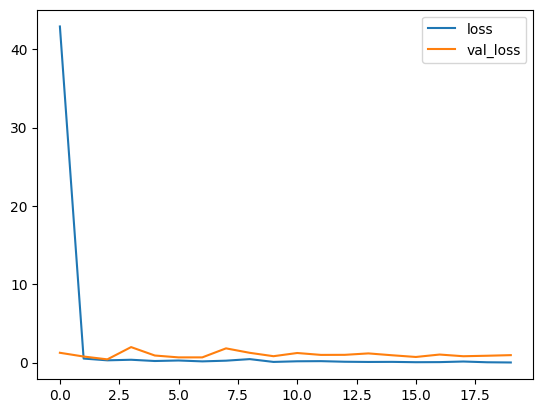

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [19]:
model_modify = Sequential([
    data_aug,
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation = 'softmax')
])

model_modify.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_modify.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              102764544 
                                                      

Dalam model_modify, ditambahkan BatchNormalization dan Dropout, BatchNormalization ditambahkan agar setiap output dari layer sebelumnya di normalisasi sehingga bisa membantu training proses untuk networknya belajar lebih mudah dan mencegah overfitting. Dropout ditambahkan agar network bisa belajar dari sub-network lain setiap kali ada batch baru data dan membantu mencegah overfitting. Jadi BatchNormalization membantu untuk training proses menjadi lebih stabil dan cepat dan Dropout membantu network agar tidak berkegantungan dengan neuron tertentu saja. Selain itu ditambahkan juga padding same agar pixel terluar dari image bisa terlihat.

In [20]:
history1 = model_modify.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/20
41/41 [==============================] - 12s 215ms/step - loss: 4.7901 - accuracy: 0.7438 - val_loss: 8.2800 - val_accuracy: 0.7888
Epoch 2/20
41/41 [==============================] - 7s 173ms/step - loss: 0.7405 - accuracy: 0.9045 - val_loss: 2.3942 - val_accuracy: 0.8696
Epoch 3/20
41/41 [==============================] - 7s 174ms/step - loss: 0.5379 - accuracy: 0.9356 - val_loss: 3.8539 - val_accuracy: 0.8509
Epoch 4/20
41/41 [==============================] - 8s 190ms/step - loss: 0.5299 - accuracy: 0.9270 - val_loss: 1.3709 - val_accuracy: 0.9006
Epoch 5/20
41/41 [==============================] - 7s 174ms/step - loss: 0.2942 - accuracy: 0.9503 - val_loss: 1.3169 - val_accuracy: 0.9006
Epoch 6/20
41/41 [==============================] - 7s 169ms/step - loss: 0.1815 - accuracy: 0.9643 - val_loss: 1.2505 - val_accuracy: 0.8944
Epoch 7/20
41/41 [==============================] - 7s 170ms/step - loss: 0.1506 - accuracy: 0.9643 - val_loss: 0.9808 - val_accuracy: 0.9006
Epoch

In [21]:
model_modify.evaluate(x_test, y_test)

6/6 [==============================] - 1s 100ms/step - loss: 1.1968 - accuracy: 0.9627


[1.1968472003936768, 0.9627329111099243]

Minimum validation loss: 0.35781627893447876


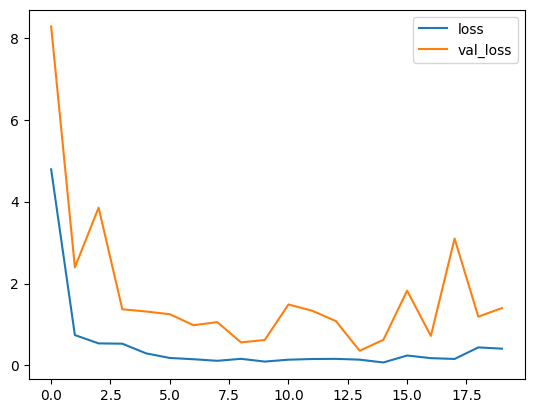

In [22]:
history_df1 = pd.DataFrame(history1.history)
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df1['val_loss'].min()))

In [23]:
y_pred = model_modify.predict(x_test)
y_pred[:10]

6/6 [==============================] - 1s 133ms/step


array([[1.0000000e+00, 4.9111709e-12, 3.9161776e-15, 1.5932356e-15],
       [0.0000000e+00, 7.9904334e-19, 1.0000000e+00, 0.0000000e+00],
       [7.6667455e-22, 2.5357652e-24, 1.5057615e-21, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.3649724e-17, 4.8363824e-17, 2.2212237e-21],
       [0.0000000e+00, 9.8841572e-01, 1.1584250e-02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

In [24]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:10]

[0, 2, 3, 2, 0, 1, 3, 1, 3, 1]

In [25]:
y_test[:10]

array([0, 2, 3, 2, 0, 2, 3, 1, 3, 1])

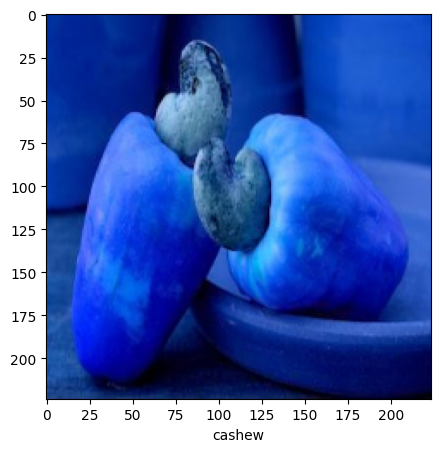

In [28]:
classes = ["cashew", "cempedak", "coconut", "cranberry"]

def show_image(x, y, index):
  plt.figure(figsize = (15,5))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

show_image(x_test, y_test, 0)

In [33]:
from tensorflow.keras.preprocessing import image

img_path = '/content/kelapa.jpeg'
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis = 0)
img_array = img_array / 255.0
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_label = classes[predicted_class_index]
print("It is a", predicted_label, "fruit!")

1/1 [==============================] - 0s 28ms/step
It is a coconut fruit!
